In [4]:
from langchain_core.tools import tool
from datetime import datetime
from langgraph.prebuilt import ToolNode


@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["sf", "san francisco"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."


@tool
def get_today_date():
    """Call to get the current date."""

    return datetime.now().strftime("%B %d, %Y")

tools = [get_weather, get_today_date]
tool_node = ToolNode(tools=tools)


In [30]:
from langchain_groq.chat_models import ChatGroq
from typing import Annotated, TypedDict, Annotated
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition
from langchain_core.messages import ToolMessage


llm = ChatGroq(model="deepseek-r1-distill-llama-70b",temperature=0,streaming=True)

class AgentState(TypedDict):
    """State of the agent."""
    messages: Annotated[list[BaseMessage], add_messages]

def agent(state: AgentState):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to use the 'get_weather'or 'get_today_date' tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    llm_with_tool = llm.bind_tools(tools=tools)
    response = llm_with_tool.invoke(state["messages"])

    return {
        "messages": [response]
    }


def should_continue(state: AgentState) -> str:
    last_msg = state["messages"][-1]

    if isinstance(last_msg, ToolMessage):
        return "__end__"
    return "agent"

workflow = StateGraph(AgentState)

workflow.add_node("agent", agent)
workflow.add_edge(START, "agent")

workflow.add_node("tools", tool_node)
workflow.add_conditional_edges("agent",tools_condition,{
    "tools": "tools",
    "end": END
})

workflow.add_conditional_edges("tools",should_continue)
    

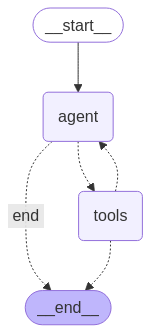

In [31]:
from IPython.display import Image, display
graph = workflow.compile()

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [37]:
# response = graph.invoke({
#     "messages": [{
#         "role": "user",
#         "content": "What is today's date?"
#     }]
# }, debug=True)

# print(response)

for s in graph.stream({
    "messages": [{
        "role": "user",
        "content": "Ajker weather kemon?"
    }]
}):
    print(s)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_cenv', 'function': {'arguments': '{"location": "Dhaka"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_454c494f52'}, id='run-224f6570-7d56-4b7a-90d7-897cf0c4d1e2-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Dhaka'}, 'id': 'call_cenv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 154, 'output_tokens': 254, 'total_tokens': 408})]}}
{'tools': {'messages': [ToolMessage(content="It's 90 degrees and sunny.", name='get_weather', id='1c997f4e-b416-4816-822e-c6d17b26a1ab', tool_call_id='call_cenv')]}}
